# Kaggle: facial keypoints detection

# Introduction

## Overview (from [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/overview))


The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

- tracking faces in images and video
- analysing facial expressions
- detecting dysmorphic facial signs for medical diagnosis
- biometrics / face recognition

Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

This getting-started competition provides a benchmark data set and an R tutorial to get you going on analysing face images. Get started with R >>

Acknowledgements
The data set for this competition was graciously provided by Dr. Yoshua Bengio of the University of Montreal. James Petterson.

# Dataset description (from Kaggle)

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files

- training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
- test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels
- submissionFileFormat.csv: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict. 

# Strategy

Step 1
- import data, check, clean
- visu data

Step 2
- create base model by averageing keypoints position
- create a submission file and get a score for the base model

Step3
- import pretrained model
- pass images through
- finetune the last layers to predict keypoint positions

# Imports

In [1]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import OrderedDict

In [2]:
use_drive = True
if use_drive:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data overview

In [22]:
# Import keypoints
if use_drive:
    base_path = "/content/drive/MyDrive/00_Data_science/Kaggle_facial_keypoints/"
else:
    base_path = "./"

keypoints_df = pd.read_csv(base_path + "data/training.csv",
                            usecols=range(30)) # /!\ using a subset


# Import images
images_df = pd.read_csv(base_path + "data/training.csv",
                         usecols = [30])

# convert images to numpy array, reshape and rescale
images_df['Image'] = images_df['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape(96,96)/255.0)

# train-test split
kp_df_train, kp_df_test, img_df_train, img_df_test = train_test_split(keypoints_df, images_df, test_size=0.02, random_state=42)
kp_df_train, kp_df_test, img_df_train, img_df_test = [X.reset_index(drop=True) for X in [kp_df_train, kp_df_test, img_df_train, img_df_test]]

In [23]:
# keypoints_df.head()
kp_df_train.head()
# kp_df_train.reset_index(inplace=True)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.316027,39.707919,31.209342,37.801450,58.849933,39.072322,73.464483,40.502013,38.993396,38.913503,24.060886,37.166174,55.990550,30.176537,82.201450,31.765047,44.076564,30.812134,18.977718,28.588027,45.188617,59.246819,61.391678,80.533369,28.985557,77.991624,44.235383,76.561933,43.441289,84.028027
1,64.813916,33.139905,27.139359,37.638341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.069299,67.159398,NaN,NaN,NaN,NaN,NaN,NaN,50.193908,78.124448
2,70.446316,40.405693,29.699874,41.843798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.353853,61.627453,NaN,NaN,NaN,NaN,NaN,NaN,49.353853,69.647267
3,66.301453,33.819239,31.182727,35.332983,57.521938,35.332983,72.053481,35.030367,37.843266,35.938547,22.705827,36.544111,54.797066,25.645287,80.833329,27.158699,41.778934,26.553467,14.834491,31.094699,45.411986,57.130630,62.668401,72.873633,33.907599,74.689993,47.833910,69.543197,48.136526,79.533841
4,65.274635,34.805351,31.344141,35.765647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.589788,55.931859,NaN,NaN,NaN,NaN,NaN,NaN,49.269741,67.135341


In [24]:
images_df.head()

,Image
0,"[[0.9333333333333333, 0.9254901960784314, 0.92..."
1,"[[0.8588235294117647, 0.8431372549019608, 0.8,..."
2,"[[0.5647058823529412, 0.5568627450980392, 0.62..."
3,"[[0.7568627450980392, 0.7529411764705882, 0.75..."
4,"[[0.5764705882352941, 0.5803921568627451, 0.62..."


In [25]:
keypoints_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [26]:
keypoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

There are 7049 rows in the dataset. Each row describes the keypoints related to an image. Most samples have data for the center of the left and right eye and the center of the bottom lip. Other features are available on only ~30% of the samples. My strategy is not to infer the missing values, but rather to omit them in the calculation of the loss function.

# Visualizing the data

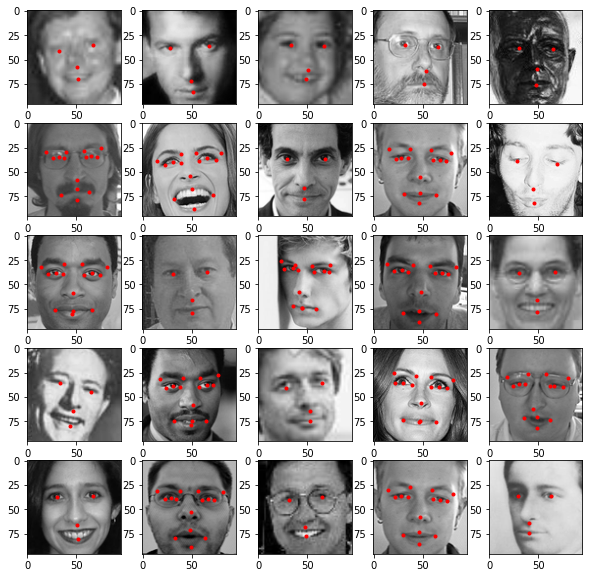

In [27]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=[10,10])

# Random samples
I = (np.random.rand(nrows*ncols) * keypoints_df.shape[0]).astype(int) 

i = 0
for ir in range(nrows):
    for ic in range(ncols):
        plt.sca(ax[ir,ic])
        plt.imshow(images_df.loc[I[i],'Image'], cmap='gray', vmin=0, vmax=1.0)
        plt.plot(keypoints_df.iloc[I[i],0::2],
                 keypoints_df.iloc[I[i],1::2],
                 '.r')
        i+=1

# Baseline model

Before, we go on to apply advanced machine learning techniques, it is useful to create a simple baseline model. The baseline is used to assess how much better the final model is performing compared to a simple solution. Here, I'll use the mean position of each keypoint as my baseline model. 

In [28]:
baseline_df_train = kp_df_train.mean()
baseline_df_test = kp_df_test.mean()

The baseline model root mean squared error (RMSE) is:

In [29]:
MSE_baseline_train = ((kp_df_train-baseline_df_train)**2).mean().mean()
MSE_baseline_test = ((kp_df_test-baseline_df_test)**2).mean().mean()
print(f"MSE, RMSE baseline: {MSE_baseline_train: .2f}, {np.sqrt(MSE_baseline_train): .2f}" )
print(f"MSE, RMSE baseline: {MSE_baseline_test: .2f}, {np.sqrt(MSE_baseline_train): .2f}" )

MSE, RMSE baseline:  13.74,  3.71
MSE, RMSE baseline:  11.78,  3.71


Let's visualize how the baseline model compares to the data

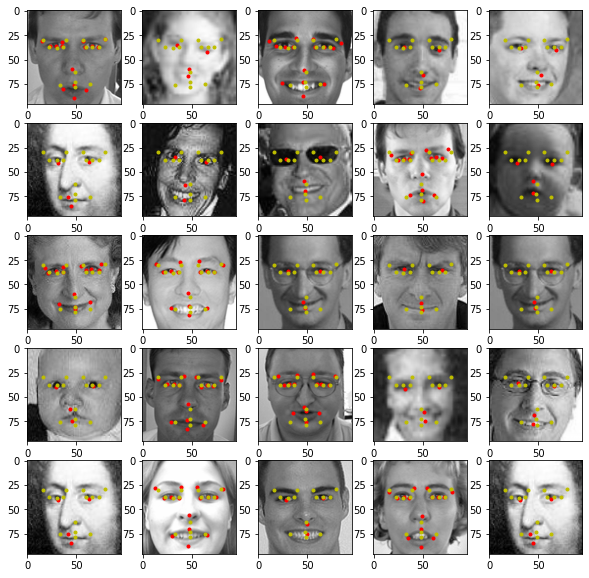

In [30]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=[10,10])

# Random samples
I = (np.random.rand(nrows*ncols) * kp_df_test.shape[0]).astype(int) 

i = 0
for ir in range(nrows):
    for ic in range(ncols):
        plt.sca(ax[ir,ic])
        plt.imshow(img_df_test.loc[I[i],'Image'], cmap='gray', vmin=0, vmax=1.0)
        plt.plot(kp_df_test.iloc[I[i],0::2],
                 kp_df_test.iloc[I[i],1::2],
                 '.r')
        plt.plot(baseline_df_test.iloc[0::2],
                 baseline_df_test.iloc[1::2],
                 '.y')
        i+=1

As we can see from the above figure, all the participants look straight into the camera, and their face is relatively well centered and with a similar scale. Thus, the baseline already gives meaningful prediction for every picture. Let's try to beat that.

# Neural network

My strategy is to pass the images through a pretrained neural network train on a classification task with the ImageNet dataset. 

## Import a pretrained model

First, I freeze the parameters because I don't need to retrain the whole model. The last layer is a fully connected layer used for classification. Let's replace it with another fully connected layer aimed at predicting the position of our keypoints. A little sanity check: all layers should have `requires_grad==False` except the last two layers (i.e., the fully convolutional and output layers).

In [31]:
def get_model(n_layers=1, verbose=False, model='resnet18', add_fc=False):
    if model=='resnet18':
        model = torchvision.models.resnet18(pretrained=True)#.features.to(device).eval()
    elif model=='resnet34':
        model = torchvision.models.resnet34(pretrained=True)#.features.to(device).eval()
    else: 
        raise ValueError(f"unknown model {model}, accepted values are 'resnet18' and 'resnet34")

    n_params = 0
    for p in model.parameters():
        n_params+=1
    i = 0

    if n_layers==-1:
        for p in model.parameters():
            p.requires_grad_(False)

    for p in model.parameters():
        if i<n_params-n_layers:
            p.requires_grad_(False)
        else: 
            break
        
        i+=1

    if add_fc:
        model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                 nn.Tanh(),
                                 nn.Linear(in_features=256, out_features=128),
                                 nn.Tanh(),
                                #  nn.Dropout(),
                                #  nn.Linear(in_features=256, out_features=128),
                                #  nn.Tanh(),
                                #  nn.Dropout(),
                                 nn.Linear(in_features=128, out_features=keypoints_df.shape[1]))
    else:
        model.fc = nn.Linear(in_features=512, out_features=keypoints_df.shape[1])
   
    # Sanity check
    if verbose:
        for p in model.parameters():
            print(p.shape, p.requires_grad)
            
    return model

# Prepare a dataloader

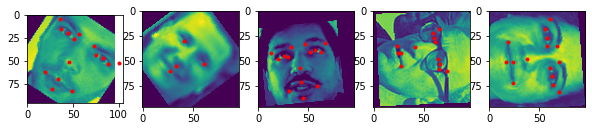

In [107]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_dataframe, label_dataframe, mode='train'):
        self.img_df = image_dataframe
        if mode != 'sub':
            self.label_df = label_dataframe
        
        self.normalize = transforms.Compose([
#             transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        self.mode = mode
    def __len__(self):
        return self.img_df.shape[0]

    def augment_data(self, img, label):
        im_size = 96
        # Random transformation of image and label
        maxshift = 8#im_size/12
        maxdegrees = 130.0
        dx, dy = ((np.random.rand(2)-0.5)*2.*maxshift).astype(int)
        
#         dx, dy = 10,20
        scale = np.random.rand()+.5 # scaling between 0.5 and 1.5
        degrees = (np.random.rand()-0.5)*2.*maxdegrees
#         degrees=30.0
        scale = 0.8+np.random.rand()*0.3 # range 0.7 - 1.1
        # scale = 1.0

        # zero out random thickness at the borders of the image (to avoid the model from learning the position of features related to the outline of the image)
        max_border_tick = 4
        x0, x1, y0, y1 = (np.random.rand(4)*max_border_tick*np.array([1., 1., 0.2, 2.0])).astype(int)
        x0 = im_size-x0
        y0 = im_size-y0
        img[:,:,:x1] = 0
        img[:,:,x0:] = 0
        img[:,:y1,:] = 0
        img[:,y0:,:] = 0



        img = torchvision.transforms.functional.affine(img, angle=degrees, translate=[dx, dy],scale=scale,shear=0.0)
#         img = torchvision.transforms.functional.affine(img, angle=degrees, translate=[0.0, 0.0],scale=1.0,shear=0.0)
        
        theta = degrees/180.0*np.pi
        rot_mat = torch.tensor([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])
        label2d = torch.cat([label[::2].reshape(1,-1), label[1::2].reshape(1,-1)],dim=0)
        
        # Rotation is applied with the center of the image as the center, so we need to shift, rotate, shift back
        label2d -= im_size/2
        label2d *= scale
        label2d = rot_mat@label2d
        label2d += im_size/2
        
        label2d[0,:] += dx
        label2d[1,:] += dy
        
        label[0::2] = label2d[0,:]
        label[1::2] = label2d[1,:]



        return img, label
    
    def __getitem__(self, index):
        
        img = torch.from_numpy(self.img_df.iloc[index].item()).reshape(1,96,96)
        if self.mode == 'sub':
            label = torch.tensor([])
        else:
            label = torch.from_numpy(np.array(self.label_df.iloc[index]))#.astype(torch.float64)
        
        img = (torch.cat([img,img,img],dim=0)).float()
        # img = img.float()
        if self.mode == 'train':
            img, label = self.augment_data(img, label)
        
        return (
            self.normalize(img), # making a RGB image out of a gray one
            # img,
            label.float()
        )

dataset_train = MyDataset(img_df_train, kp_df_train, mode='train')
# dataset_train.__getitem__(0)

# Test dataset
# dataset = MyDataset(images_df, keypoints_df)
batch_size = 1
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
n = 5
fig, ax = plt.subplots(1,5,figsize=[10,5])
for i, (img, label) in enumerate(dataloader):
    plt.sca(ax[i])
    plt.imshow(img[0,0,:,:])
    plt.plot(label[0,::2],label[0,1::2],'.r')
    if i==n-1:
        break

# Training function

In [108]:
def train(model, dataloader, loss_fn, optimizer, n_epoch, scheduler=None, device='cpu', n_out=5):
    n_batch = len(dataloader)
    n_print = int(len(dataloader)/n_out)
    
    for i_epoch in range(n_epoch):
        print(f"Epoch {i_epoch:03d} ======")
        total_loss = 0.0
        for i_batch, (img, label) in enumerate(dataloader):
            img = img.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            out = model(img)
            # print(out)
            I = torch.isnan(label)
            label = label[~I]
            out = out[~I]
            loss = loss_fn(out, label)
            # loss /= (30-I.sum())
            loss.backward()
            total_loss += loss.item()
            # print("opt")
            optimizer.step()
            
            # print(f"i_batch {i_batch}: tl: {total_loss:.2e}")
            # if i_batch%n_print==0:
            #     with torch.no_grad():
            #         print(f"batch {i_batch}/{n_batch}, loss: {loss.item()}")
        if scheduler:
        # print("sch")
            scheduler.step()
        print(f"total loss: {total_loss/len(dataloader):.2e}")

# Testing function

In [109]:
def test(model, dataloader, loss_fn):
    n_batch = len(dataloader)
    with torch.no_grad():
        loss = 0
        for i_batch, (img, label) in enumerate(dataloader):
            img = img.to(device)
            label = label.to(device)
            out = model(img)
            I = torch.isnan(label)
            label = label[~I]
            out = out[~I]
            loss += loss_fn(out, label).item()# / (30-I.sum())
        print(f"test loss: {loss/len(dataloader):.2e}")

In [110]:
def compute_sub(model, dataloader):
    out_big = []
    with torch.no_grad():
        loss = 0
        for i_batch, (img, label) in enumerate(dataloader):
            img = img.to(device)
            out_big.append(model(img))
    return torch.cat(out_big,dim=0)

# My model

In [119]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.layer1 = self._make_block(1,128)
        self.layer1_1 = self._make_block(128,256)
        self.layer2 = self._make_block(256,256)
        self.layer3 = self._make_block(256,256)
        self.layer4 = self._make_block(256,256)
        # self.layer5 = self._make_block(32,256)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.maxpool2 = nn.MaxPool2d(kernel_size=(3,2), stride=(2,2), padding=(0,0))
        self.adapt = nn.AdaptiveAvgPool2d((1,1))
        self.fc     = nn.Sequential(nn.Linear(256,256),
                                    nn.LeakyReLU(),
                                    nn.Dropout(),
                                    nn.Linear(256,256),
                                    nn.LeakyReLU(),
                                    nn.Dropout(),
                                    nn.Linear(256,30))
        self.conv_1d_1 = nn.Conv2d(256,64,1,padding=0)
        self.conv_1d_2 = nn.Conv2d(256,30,1,padding=0)


    def _make_block(self, in_features, out_features):
        in_f = in_features
        out_f = out_features
        return nn.Sequential(OrderedDict([
                                ("conv1", nn.Conv2d(in_f,out_f,3,padding=1)),
                                ("bn1", nn.BatchNorm2d(out_f)),
                                ("relu", nn.ReLU()),
                                ("conv2", nn.Conv2d(out_f,out_f,3,padding=1)),
                                ("bn2", nn.BatchNorm2d(out_f)),
                                ("relu", nn.ReLU()),
                                #("maxpool", nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
                             ])
                            )

    def forward(self, x):
        # print(x.shape)
        x = self.layer1(x)
        x = self.layer1_1(x)
        x = self.maxpool(x)
        # x = self.conv_1d_1(x)
        # x = F.relu(x)
        # x = F.dropout(x)
        x = self.layer2(x)
        x = self.maxpool(x)
        # x = self.conv_1d_1(x)
        # x = F.relu(x)
        # x = F.dropout(x)
        x = self.layer3(x)
        x = self.maxpool(x)
        # x = self.conv_1d_1(x)
        # x = F.relu(x)
        # x = F.dropout(x)
        x = self.layer4(x)
        x = self.maxpool(x)
        # x = self.conv_1d_2(x)
        # x = F.relu(x)
        # x = self.layer5(x)
        # x = self.maxpool(x)
        # x = self.conv_1d_2(x)
        x = self.adapt(x)
        # print(x.shape)
        # print(x.shape)
        
        x = x.reshape(x.shape[0],-1)
        # print(x.shape)
        x = self.fc(x)

        return x

# Train

In [122]:
# Setup training
init = True
if init:
    batch_size = 64
    dataset_train = MyDataset(img_df_train, kp_df_train, mode='train')
    dataset_test = MyDataset(img_df_test, kp_df_test, mode='test')
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    model = get_model(n_layers=3,verbose=False, model='resnet18',add_fc=False).to(device)
    # model = MyNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1.0, weight_decay=0.01, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.5)
    n_epoch = 5
    loss_fn = torch.nn.MSELoss()

train(model, dataloader_train, loss_fn, optimizer, n_epoch, scheduler=scheduler, device=device, n_out=1)
test(model,dataloader_test, loss_fn)

Using device: cuda
Epoch 000 ======
total loss: 5.31e+03
Epoch 001 ======
total loss: 3.04e+02
Epoch 002 ======
total loss: 3.10e+02
Epoch 003 ======
total loss: 3.03e+02
Epoch 004 ======
total loss: 2.70e+02
test loss: 2.54e+02


# Visualize results

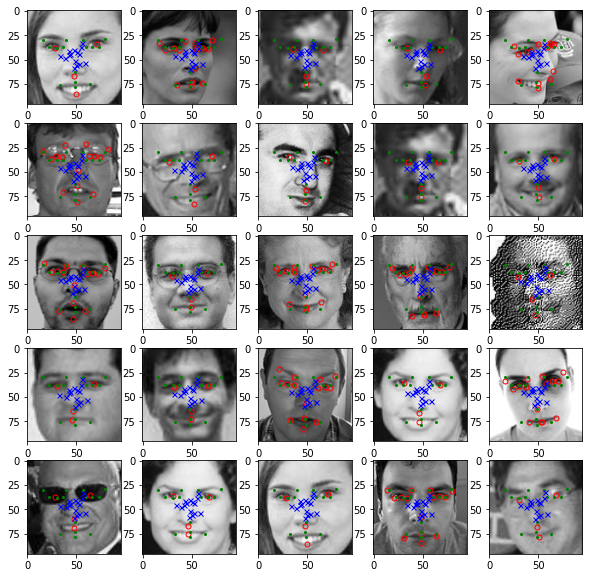

In [115]:
nrows = 5
ncols = 5
device = 'cpu'
model = model.to(device)
fig, ax = plt.subplots(nrows,ncols, figsize=[10,10])

# Random samples
I = (np.random.rand(nrows*ncols) * kp_df_test.shape[0]).astype(int)

i = 0
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

for ir in range(nrows):
    for ic in range(ncols):
        plt.sca(ax[ir,ic])
        plt.imshow(img_df_test.loc[I[i],'Image'], cmap='gray', vmin=0, vmax=1.0)
        plt.plot(kp_df_test.iloc[I[i],0::2],
                 kp_df_test.iloc[I[i],1::2],
                 'or',markersize=5.0,markerfacecolor='none')
        plt.plot(baseline_df_test.iloc[0::2],
                 baseline_df_test.iloc[1::2],
                 'og',markersize=2.0)
        
        with torch.no_grad():
            img, kp = dataset_test.__getitem__(I[i])            
            kp_predict = model(normalize(img.reshape(1,3,96,96)))[0]
            # kp_predict = model(img.reshape(1,1,96,96))[0]
#             print(kp_predict)
            plt.plot(kp_predict[0::2],
                     kp_predict[1::2],
                     'xb',markersize=5.0)
        i+=1

Note: It looks like I'm not really making a better prediction than the baseline. Maybe I need to train longer. But also, I should take care of the missing values now. Actually I was using only a really small subset of the dataset (200/7000 samples). Also, use data augmentation

# Submission

In [99]:
# Import images
img_df_sub = pd.read_csv(base_path + "data/test.csv",
                         usecols = [1])
# convert images to numpy array, reshape and rescale
img_df_sub['Image'] = img_df_sub['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape(96,96)/255.0)
# # img_df_sub.head()
dataset_sub = MyDataset(img_df_sub, [], mode='sub')
dataloader_sub = torch.utils.data.DataLoader(dataset_sub, batch_size=batch_size, shuffle=True)
out_big = compute_sub(model,dataloader_sub)

# Cutoff range
out_big[out_big>96.0] = 96.0
out_big[out_big<0.0] = 0.0


In [100]:
out_df = pd.DataFrame(out_big.cpu().numpy(), columns=kp_df_test.columns)

In [101]:
out_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,65.006241,35.168472,30.716730,38.703693,57.767555,36.856674,72.231491,34.697266,37.550205,38.909477,23.467861,39.770855,52.726677,29.886932,77.371582,27.207253,37.902676,32.590603,16.773109,33.493439,47.331245,63.926220,66.020454,74.383705,37.421158,77.042091,50.168648,76.887070,49.988998,75.973427
1,67.235619,39.326660,28.059780,37.654488,58.946869,38.995621,73.626038,39.666470,34.356102,37.956776,19.733503,37.981625,56.004524,30.043606,80.204224,31.674713,37.438118,29.148720,13.318769,29.745602,46.829323,61.142403,62.447723,75.711601,28.460522,74.892776,45.547722,72.483704,46.177574,79.029785
2,66.702171,37.644554,28.380510,39.956856,58.253876,37.787193,73.961288,36.865776,34.846931,38.900688,20.856379,39.158661,52.855858,30.596188,79.102615,27.776915,34.915428,32.385490,14.829424,30.363224,45.606430,68.344734,66.148605,76.793167,33.776897,77.732635,47.940147,79.486656,48.035309,78.772049
3,66.348083,41.312019,30.538372,40.110939,58.470268,42.227829,72.456589,42.019897,37.948284,41.621357,21.015678,40.818283,58.454140,35.903572,77.761734,34.784767,44.527794,33.863644,14.767822,33.701389,54.966026,67.295731,61.753017,83.877815,31.084280,83.912109,49.917393,84.051315,51.082783,84.102058
4,59.340103,39.336693,31.277821,38.505150,53.518173,38.444855,64.345032,38.800255,35.526329,38.032116,24.886639,37.893280,51.534958,31.346561,68.625916,31.665983,38.076393,31.329124,21.101658,31.045555,44.561016,61.290764,56.792862,71.386536,30.929777,70.266052,43.753601,71.892365,44.020447,70.533463


In [102]:
look_df = pd.read_csv(base_path + "data/IdLookupTable.csv", index_col=[0])

In [103]:
look_df.head()

,ImageId,FeatureName,Location
RowId,,,
1,1,left_eye_center_x,NaN
2,1,left_eye_center_y,NaN
3,1,right_eye_center_x,NaN
4,1,right_eye_center_y,NaN
5,1,left_eye_inner_corner_x,NaN


In [104]:
for ind in look_df.index:
    img_id, kp = look_df.loc[ind,['ImageId','FeatureName']]
    look_df.loc[ind, 'Location'] = out_df.loc[img_id-1, kp]



In [105]:
look_df.sample(10)

,ImageId,FeatureName,Location
RowId,,,
25824,1621,right_eye_center_y,33.656860
4007,134,right_eyebrow_outer_end_x,17.616283
21503,1081,right_eye_center_x,32.624809
14508,486,mouth_center_top_lip_y,73.864754
13288,445,left_eye_outer_corner_y,39.773289
26515,1707,mouth_center_bottom_lip_x,51.486687
23480,1328,right_eye_center_y,36.886612
14782,496,left_eye_center_y,39.114830
12406,415,left_eye_center_y,35.840019


In [106]:
sub_df = look_df.reset_index()[['RowId','Location']]
sub_df.to_csv(base_path + "/data/my_submission.csv", index=False)

# Conclusion

I tried different approaches to finding facial keypoints from images

- finetuning a pretrained Resnet18 model
- training a convolutional neural network from scratch
- data augmentation

In the end my CNN-based models never performed much better than the baseline (average of keypoints locations). Especially, I got worst results with data augmentation. Even with data augmentation (scaling, translating, rotating), the model still learns only the average position. That makes me think that the model somehow learns to recognize the affine transformation. Those limitations are reflected in my best score of 5.11, which is not phenomenal.

Looking at some solutions, it looks like I got all the right steps for a good basic solution. I could probably increase the score by using a different pretrained model or fiddling with the custom one. Also, I programmed the data augmentation by hand, and although I don't see any bug, it is weird that it's decreasing the quality of the prediction. Using a library for data augmentation, such as albumentation would fix this problem (I'll do that next time). I stop now, because to improve my score I have the impression that I will just need to tune the parameters and just play around... I'd rather take what I learned and use it on a new project.

I learned some valuable skills: I'm getting more and more comfortable with PyTorch. I learned how to modify and finetune a model, perform the same augmentation on image and label. I also experimented with building and training a VGG-inspired CNN from scratch, and I got more familiar with the architecture of Resnet.